In [34]:
import pandas as pd
import matplotlib.pyplot as plt

from const import MIN_TIMESTEP

In [35]:
DATE_FORMAT = '%Y-%m-%dT%H:%H%M%z'  # ISO 8601 datetime format

Define a functions to load and plot the capacity factor data.

In [36]:
def load_cf_data(tech: str) -> pd.DataFrame:
    """Load cf data from intermediate files"""
    df = (pd.read_csv(f'../data/intermediate/CF {tech}.csv',
                        index_col=0, parse_dates=True)
              .dropna(axis=1, how='all'))
    df.index.name = 'Datetime'
    df.columns.name = 'Country code'
    return df


def plot_statistics(df: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    df.plot.box(title='Distribution of values', ax=ax1, showmeans=True)
    df.interpolate('time').diff(1).plot.box(title=f'{MIN_TIMESTEP} changes', ax=ax2)
    return ax1, ax2

## Results for onshore wind power

Let’s plot some statistics about the CF time series and the change time series. Box plots show 1st, 2nd and 3rd quartile as well as the mean (triangles) of the data. Note that also for countries with only hourly data, changes are calculated from interpolated 15-minute time series to make them comparable.

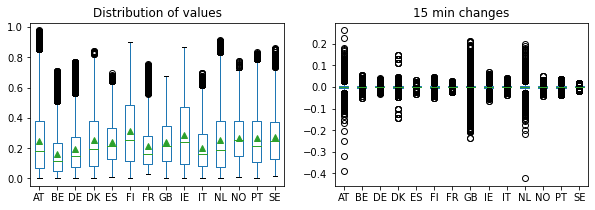

In [37]:
tech = 'Wind Onshore'
cf_wind_onshore = load_cf_data(tech)
plot_statistics(cf_wind_onshore);

Some very high values for Austria (AT). Let’s plot the time series.

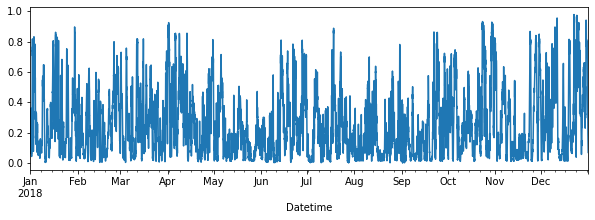

In [38]:
cf_wind_onshore['AT'].tz_localize(None).plot(figsize=(10, 3));

Let’s look at the installed capacities. We used numbers from WindEurope in the cap. factors calculations. ENTSO-E also has that data.

In [39]:
installed_cap_windeurope = pd.read_csv('../data/intermediate/WindEurope_installed_cap.csv', 
                                       index_col=0, header=[0,1])
installed_cap_entsoe = pd.read_csv("../data/raw/ENTSO-E_TP_installed_cap.csv", 
                                   index_col=[0, 1], header=0)
wind_cap_onshore_at = pd.DataFrame({'windeurope': installed_cap_windeurope.loc['Austria', 
                                                                               'Cumulative onshore capacity'],
                                    'entso-e': installed_cap_entsoe.loc['Wind Onshore', 'AT']})
wind_cap_onshore_at

,windeurope,entso-e
Year,,
2017,2844.0,2696.0
2018,3045.0,2887.0


Let’s calculate means too.

In [40]:
wind_cap_onshore_at.mean()

windeurope    2944.5
entso-e       2791.5
dtype: float64

It seems that ENTSO-E has on average lower installed capacity which then should not lead to too *high* capacity factors.

Check coverages

In [41]:
pd.read_csv(f'../data/intermediate/Coverage {tech}.csv', index_col=0)

,length,original,interpolated,missing
AT,35040.0,1.000000,NaN,NaN
BE,8760.0,1.000000,NaN,NaN
DE,35040.0,1.000000,NaN,NaN
DK,8760.0,1.000000,NaN,NaN
ES,8760.0,0.999886,1.000000,0.0
FI,8760.0,0.999772,1.000000,0.0
FR,8760.0,0.999543,1.000000,0.0
GB,17520.0,0.999715,1.000000,0.0
IE,17520.0,0.999429,1.000000,0.0
IT,8760.0,0.998858,0.999315,6.0


Write final files, including data for Austria.

In [42]:
cf_wind_onshore.to_csv('../data/processed/CF Wind Onshore.csv', header=True)

Create a summary table

In [43]:
summary = pd.DataFrame(index=cf_wind_onshore.columns)
summary['Wind Onshore'] = 'OK'
summary.loc['IT', 'Wind Onshore'] = 'gaps'
summary

,Wind Onshore
Country code,
AT,OK
BE,OK
DE,OK
DK,OK
ES,OK
FI,OK
FR,OK
GB,OK
IE,OK


## Results for offshore wind power

Let’s plot the same statistics for offshore wind.

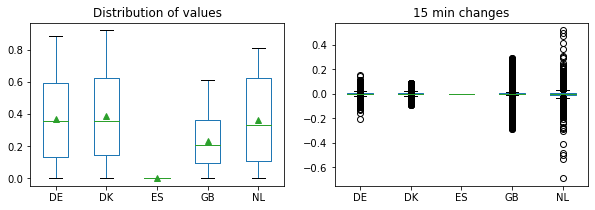

In [44]:
tech = 'Wind Offshore'
cf_wind_offshore = load_cf_data(tech)
plot_statistics(cf_wind_offshore);

Clearly something wrong with Belgium and Spain. Let’s plot the time series.

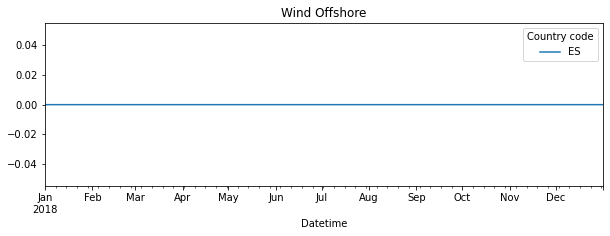

In [45]:
cf_wind_offshore[['ES']].dropna().plot(figsize=(10, 3), title=tech);

Clearly, Spain acctually has no data. 

Check coverages

In [46]:
pd.read_csv(f'../data/intermediate/Coverage {tech}.csv', index_col=0)

,length,original,interpolated,missing
DE,35040.0,1.000000,NaN,NaN
DK,8760.0,1.000000,NaN,NaN
ES,8760.0,0.999886,1.0,0.0
GB,17520.0,0.999715,1.0,0.0
NL,35040.0,0.999658,1.0,0.0


Write final files, excluding Spain.

In [47]:
cf_wind_offshore.drop(['ES'], axis=1).to_csv('../data/processed/CF Wind Offshore.csv', header=True)

Update the summary table.

In [48]:
summary.loc[cf_wind_offshore.columns, 'Wind Offshore'] = 'OK'
summary.loc['ES', 'Wind Offshore'] = 'n/a'
summary.loc['BE', 'Wind Offshore'] = 'errors'
summary = summary.fillna('n/a')
summary

,Wind Onshore,Wind Offshore
Country code,,
AT,OK,n/a
BE,OK,errors
DE,OK,OK
DK,OK,OK
ES,OK,n/a
FI,OK,n/a
FR,OK,n/a
GB,OK,OK
IE,OK,n/a


## Solar power

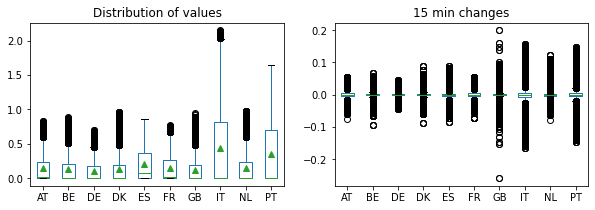

In [49]:
tech = 'Solar'
cf_solar = load_cf_data(tech)
plot_statistics(cf_solar);

Data for Italy and Portugal is errorneous. Let’s drop these.

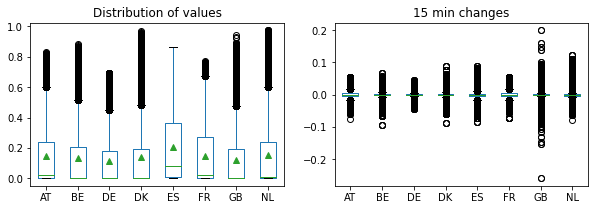

In [50]:
plot_statistics(cf_solar.drop(['IT', 'PT'], axis=1));

Let’s check the maximum values still.

In [51]:
cf_solar.drop(['IT', 'PT'], axis=1).max()

Country code
AT    0.834773
BE    0.887233
DE    0.694729
DK    0.969398
ES    0.861849
FR    0.769545
GB    0.946543
NL    0.975872
dtype: float64

None above one at least. Let’s write final files.

In [52]:
cf_solar.drop(['IT', 'PT'], axis=1).to_csv('../data/processed/CF Solar.csv', header=True)

Check coverages

In [72]:
coverage_solar = pd.read_csv(f'../data/intermediate/Coverage {tech}.csv', index_col=0)
coverage_solar

,length,original,interpolated,missing
AT,35040.0,1.000000,NaN,NaN
BE,8760.0,1.000000,NaN,NaN
DE,35040.0,1.000000,NaN,NaN
DK,8760.0,1.000000,NaN,NaN
ES,8760.0,0.999886,1.000000,0.0
FR,8760.0,0.999658,1.000000,0.0
GB,17520.0,0.999715,1.000000,0.0
IT,8760.0,0.998973,0.999429,5.0
NL,35040.0,0.991781,0.992009,280.0
PT,8760.0,1.000000,NaN,NaN


Update the summary.

In [78]:
summary.loc[cf_solar.columns, 'Solar'] = 'OK'
summary.loc[['IT', 'NL'], 'Solar'] = 'gaps'
summary.loc[['IT', 'PT'], 'Solar'] = 'errors'
summary.fillna('n/a', inplace=True)
summary

,Wind Onshore,Wind Offshore,Solar,Load
Country code,,,,
AT,OK,n/a,OK,OK
BE,OK,errors,OK,OK
DE,OK,OK,OK,gaps
DK,OK,OK,OK,errors
ES,OK,n/a,OK,OK
FI,OK,n/a,n/a,OK
FR,OK,n/a,OK,gaps
GB,OK,OK,OK,errors
IE,OK,n/a,n/a,OK


## Load data

In [55]:
load_data = pd.read_csv('../data/intermediate/Load.csv', index_col=0, parse_dates=True)

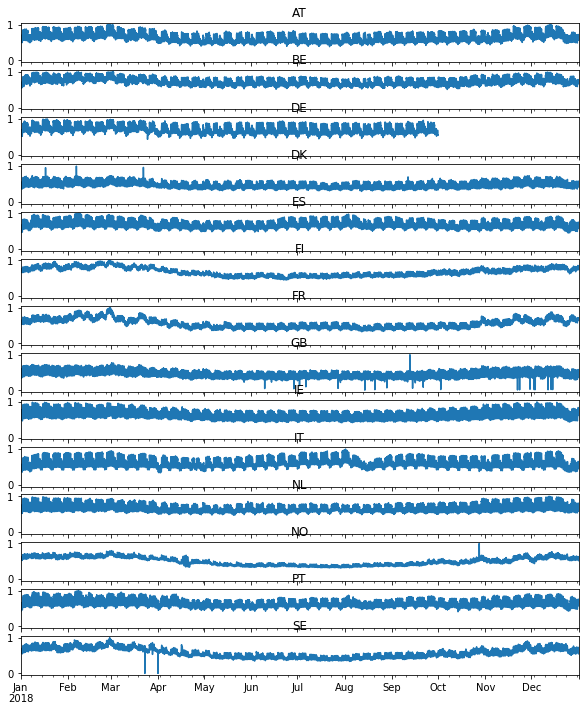

In [56]:
fig, axs = plt.subplots(nrows=len(load_data.columns), 
                        sharey=True, sharex=True,
                        figsize=(10, 12))
relative_load = load_data.div(load_data.max())
for ax, c in zip(axs, load_data.columns):
    relative_load[c].dropna().plot(ax=ax, title=c);

Germany has data after Sept/Oct missing. Some countries have high peaks too: 

Let’s check the statistics.

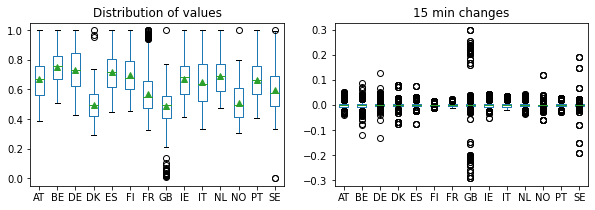

In [57]:
plot_statistics(relative_load);

Check coverages

In [58]:
coverage = pd.read_csv(f'../data/intermediate/Coverage Load.csv', index_col=0)
coverage

,length,original,interpolated,missing
AT,35040.0,1.000000,NaN,NaN
BE,35040.0,1.000000,NaN,NaN
DE,35040.0,0.747317,0.747603,8844.0
DK,8760.0,1.000000,NaN,NaN
ES,8760.0,0.999772,1.000000,0.0
FI,8760.0,0.999658,1.000000,0.0
FR,8760.0,0.997945,0.999886,1.0
GB,17520.0,0.999772,1.000000,0.0
IE,17520.0,0.998744,1.000000,0.0
IT,8760.0,1.000000,NaN,NaN


Update the summary

In [67]:
summary.loc[['AT', 'BE', 'ES', 'FI', 'FR', 'IE', 'IT', 'NL', 'PT'], 'Load'] = 'OK'
summary.loc[coverage['missing'] > 0, 'Load'] = 'gaps'
summary.loc[['DK', 'GB', 'NO', 'SE'], 'Load'] = 'errors'
summary.sort_index()

,Wind Onshore,Wind Offshore,Solar,Load
Country code,,,,
AT,OK,n/a,OK,OK
BE,OK,errors,OK,OK
DE,OK,OK,OK,gaps
DK,OK,OK,OK,errors
ES,OK,n/a,OK,OK
FI,OK,n/a,n/a,OK
FR,OK,n/a,OK,gaps
GB,OK,OK,OK,errors
IE,OK,n/a,n/a,OK


### Cleaning errors in the load time series

Let’s plot around the maximum in UK.

Timestamp('2018-09-12 16:00:00+0000', tz='UTC')

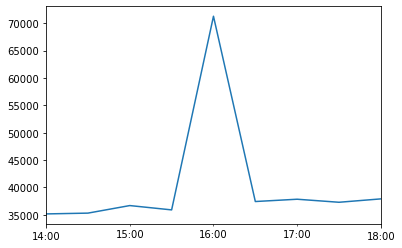

In [60]:
t_peak = load_data['GB'].idxmax()
delta_t = pd.Timedelta(2, 'hours')
load_data.loc[t_peak - delta_t: t_peak + delta_t, 'GB'].dropna().tz_localize(None).plot();
t_peak

This is clearly an error. We can try to find all steps with large changes in the load.

In [61]:
def shave_load_peaks(ts: pd.Series, threshold: float = 0.99) -> pd.Series:
    ts_out = ts.copy()
    window_size = 3
    rolling_median = ts.rolling(window_size, center=True).median()
    score = (rolling_median - ts).div(rolling_median).abs()    
    ts_out[score > score.quantile(threshold)] = pd.np.nan
    return ts_out.interpolate('time')


In [62]:
clean = shave_load_peaks(load_data['GB'].dropna(), 0.9)
clean.max(), clean.min()

<ipython-input-61-b00b3d81daa1>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ts_out[score > score.quantile(threshold)] = pd.np.nan


(54315.0, 1962.0)

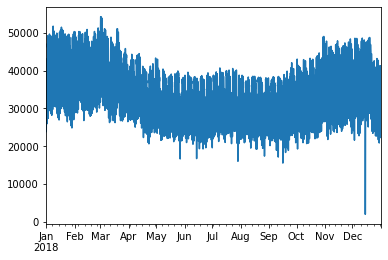

In [63]:
clean.plot()

In [64]:
ts = load_data['GB'].dropna()
ts_out = ts.copy()
window_size = 3
threshold = 0.9
rolling_median = ts.rolling(window_size, center=True).median()
score = (rolling_median - ts).div(rolling_median).abs()    
ts[score > score.quantile(threshold)]

2018-01-01 00:30:00+00:00    31096.0
2018-01-01 05:00:00+00:00    23648.0
2018-01-01 13:00:00+00:00    39619.0
2018-01-01 13:30:00+00:00    38806.0
2018-01-01 14:00:00+00:00    39001.0
                              ...   
2018-12-31 04:30:00+00:00    22123.0
2018-12-31 10:30:00+00:00    37896.0
2018-12-31 12:30:00+00:00    38619.0
2018-12-31 15:00:00+00:00    36812.0
2018-12-31 17:00:00+00:00    41764.0
Name: GB, Length: 1752, dtype: float64

In [65]:
zscore(ts)

NameError: name 'zscore' is not defined

In [ ]:
# From: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe
def zscore_func(x, window):
    """Calculate z-score over a rolling window of size `window`
    """
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x - m) / s
    return z

In [ ]:
abs_z = zscore_func(ts, window=3).abs()

In [ ]:
ts[abs_z > abs_z.quantile(0.9999)]

In [ ]:
ts['2018-02-05 14:30:00+00:00': '2018-02-05 16:30:00+00:00']

In [ ]:
ts = load_data['GB'].dropna()
rel_delta = ts.diff(1).div(ts)

In [ ]:
rel_delta[ts.idxmax()]

In [ ]:
ts[rel_delta > rel_delta.quantile(0.995)]